In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coloncancerdataset/traindata.parquet


In [2]:
!pip install pyarrow

In [3]:
!pip install fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.4 MB/s eta 0:00:00:00:01


In [4]:
import pandas as pd
import numpy as np
import pyarrow
import fastparquet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

In [6]:
data = pd.read_parquet('/kaggle/input/coloncancerdataset/traindata.parquet')

In [9]:
data.head(10)

,image,ImageType,StudyDate,SeriesDate,Manufacturer,StudyDescription,SeriesDescription,PatientSex,PatientAge,PregnancyStatus,BodyPartExamined
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
5,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
6,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
7,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
8,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
9,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON


In [8]:
data.tail(10)

,image,ImageType,StudyDate,SeriesDate,Manufacturer,StudyDescription,SeriesDescription,PatientSex,PatientAge,PregnancyStatus,BodyPartExamined
20,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
21,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
22,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
23,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
24,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
25,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
26,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
27,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
28,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON
29,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI]",20000101,20000101,SIEMENS,Abdomen^24ACRIN_Colo_IRB2415-04 (Adult),Colo_prone 1.0 B30f,F,059Y,None,COLON


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image              30 non-null     object
 1   ImageType          30 non-null     object
 2   StudyDate          30 non-null     object
 3   SeriesDate         30 non-null     object
 4   Manufacturer       30 non-null     object
 5   StudyDescription   30 non-null     object
 6   SeriesDescription  30 non-null     object
 7   PatientSex         30 non-null     object
 8   PatientAge         30 non-null     object
 9   PregnancyStatus    30 non-null     object
 10  BodyPartExamined   30 non-null     object
dtypes: object(11)
memory usage: 2.7+ KB


In [12]:
# check missing data

missing_values = data.iloc[:, :20].isnull().sum()

missing_values


image                0
ImageType            0
StudyDate            0
SeriesDate           0
Manufacturer         0
StudyDescription     0
SeriesDescription    0
PatientSex           0
PatientAge           0
PregnancyStatus      0
BodyPartExamined     0
dtype: int64

In [15]:
# check column

print(data.columns)

Index(['image', 'ImageType', 'StudyDate', 'SeriesDate', 'Manufacturer',
       'StudyDescription', 'SeriesDescription', 'PatientSex', 'PatientAge',
       'PregnancyStatus', 'BodyPartExamined'],
      dtype='object')


In [17]:
# clean data for times and ages

In [25]:
import pandas as pd

# Assuming a DataFrame with both numeric (with prefixes/suffixes) and date columns
data = pd.read_parquet('/kaggle/input/coloncancerdataset/traindata.parquet')

# Function to clean and convert numeric-like values
def clean_and_convert(value):
    cleaned_value = value.str.replace('[^0-9]', '', regex=True).str.lstrip('0')
    return pd.to_numeric(cleaned_value, errors='coerce')

# Apply the function to the numeric-like column
data['cleaned_column'] = clean_and_convert(data['StudyDate'])
data['cleaned_column'] = clean_and_convert(data['SeriesDate'])

# Apply the function to the column
data['cleaned_column'] = clean_and_convert(data['PatientAge'])

# Convert strings to datetime if they are not already
data['StudyDate'] = pd.to_datetime(data['StudyDate'])
data['SeriesDate'] = pd.to_datetime(data['SeriesDate'])

# Convert date columns to NumPy arrays if needed for further processing
study_date_np = data['StudyDate'].values
series_date_np = data['SeriesDate'].values

# Save the cleaned and processed DataFrame to a new CSV file
data.to_csv('cleaned_data.csv', index=False)

# Display the types to confirm conversion and the first few rows of cleaned data
print(type(study_date_np), study_date_np.dtype)
print(type(series_date_np), series_date_np.dtype)
print(data.head())

<class 'numpy.ndarray'> datetime64[ns]
<class 'numpy.ndarray'> datetime64[ns]
                                               image  \
0  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
2  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
3  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
4  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

                                 ImageType  StudyDate SeriesDate Manufacturer  \
0  [ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI] 2000-01-01 2000-01-01      SIEMENS   
1  [ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI] 2000-01-01 2000-01-01      SIEMENS   
2  [ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI] 2000-01-01 2000-01-01      SIEMENS   
3  [ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI] 2000-01-01 2000-01-01      SIEMENS   
4  [ORIGINAL, PRIMARY, AXIAL, CT_SOM5 SPI] 2000-01-01 2000-01-01      SIEMENS   

                          StudyDescription      SeriesDescription PatientSex  \
0  Abdomen^24ACRIN

In [30]:
print(data.columns)

Index(['image', 'ImageType', 'StudyDate', 'SeriesDate', 'Manufacturer',
       'StudyDescription', 'SeriesDescription', 'PatientSex', 'PatientAge',
       'PregnancyStatus', 'BodyPartExamined', 'cleaned_column'],
      dtype='object')


Machine Learning in NumPy

Data Visualization Using Histogram 

- The distribution of ages

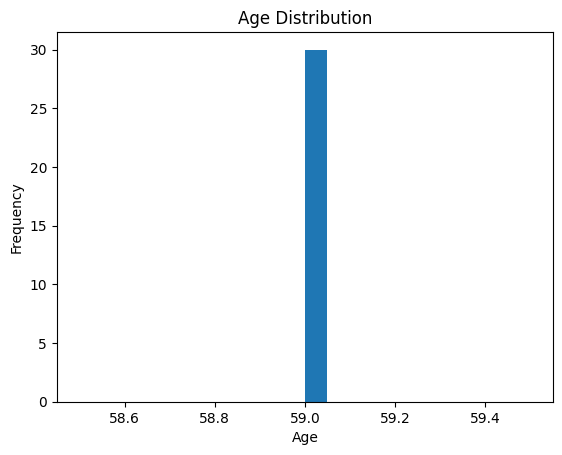

In [31]:
import matplotlib.pyplot as plt
import numpy as np

ages = data['cleaned_column']  # Replace 'age_column' with the actual column name
plt.hist(ages, bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [33]:
!pip install Pillow

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Split Data into Training and Testing Sets

In [40]:
import pandas as pd
import numpy as np
from PIL import Image
import io

# Load the dataset
data = data

# Prepare images
def prepare_images(data, image_column):
    images = []
    for idx, row in data.iterrows():
        # Extract bytes from the dictionary
        if 'bytes' in row[image_column]:
            image_data = row[image_column]['bytes']
        else:
            # Handle cases where the image data might not be in the expected format
            print(f"No image data found for row {idx}, skipping.")
            continue
        image = Image.open(io.BytesIO(image_data))
        image = image.resize((128, 128))  # Resize to uniform size, adjust as needed
        images.append(np.array(image))
    return np.stack(images)  

In [41]:
image_array = prepare_images(data, 'image')

Encode Labels

In [42]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(data['cleaned_column'])  # Add column's name
labels_categorical = to_categorical(labels_encoded)

In [44]:
label_encoder

LabelEncoder()

Split Data Into Training and Testing Sets

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_array, labels_categorical, test_size=0.2, random_state=42)

TensorFlow for a hypothetical image classification

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Assuming images are grayscale, set channels=1. Set channels=3 for RGB images.
channels = 1  # or 3 for RGB
num_classes = labels_categorical.shape[1]  # Based on your label encoding

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, channels)),
    MaxPooling2D(2, 2),
    # Add more layers as needed...
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step - accuracy: 1.0000 - loss: